<a href="https://colab.research.google.com/github/anuranjpr/cowpea-weed-classification/blob/main/Cowpea_Weed_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
  <b><font size=6.5 face="Times">
    _Cowpea_Weed_Classifier
  </font></b><br/>
  <font size=4 face="brush script"><i>
    An AI-based Software for Pre-processing and Experimenting 'CowpeaWeedDataset_Classification' dataset in Python
  </i></font>
</center>

<font face="cursive">
  <h6>Related references:</h6>
  <a href="https://github.com/JustinaMichael/CNN_Sorghum-Weed_Classifier.git">GitHub repository for source code</a> <br/>
  <a href="https://github.com/JustinaMichael/SorghumWeedDataset_Classification.git">GitHub repository for dataset</a> <br/>
  <a href="https://data.mendeley.com/datasets/4gkcyxjyss/1">Mendeley data repository for dataset(First appeared) </a>
</font>


### Cloning the 'Cowpea-weed-classification' dataset from GitHub repository

In [25]:
!git clone https://github.com/anuranjpr/cowpea-weed-classification.git

Cloning into 'cowpea-weed-classification'...
remote: Enumerating objects: 2951, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 2951 (delta 4), reused 3 (delta 0), pack-reused 2933
Receiving objects: 100% (2951/2951), 43.37 MiB | 35.98 MiB/s, done.
Resolving deltas: 100% (6/6), done.


## Data Pre-processing
### Importing necessary libraries

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from glob import glob
import itertools
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np, cv2
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from numpy import expand_dims
from google.colab.patches import cv2_imshow
from skimage.io import imsave

### Variable declaration

In [26]:

root_path = r"/content/cowpea-weed-classification/"
train_path=root_path+'/Train/'
validation_path=root_path+'/Validate/'
test_path=root_path+'/Test/'

# Finding total number of classes
num_classes = len(glob(test_path + '/*'))

# Random seed setting to inititalize same random weights every time when we build the model
tf.random.set_seed(0)

### Initializing tuned hyper-parameter values

In [27]:
# Declaring the number of epochs
epochs = 50

# Image resize
img_size = 224

# Decalring batch size
batch_size = 32

# Class mode for data augmentation
class_mode = 'categorical'

# Declaring learning rate
my_learning_rate = .001

# Declaring the model loss funtion
loss = 'categorical_crossentropy'

# Activation function
activation = 'softmax'

# URL of the single image from test data
single_image_path = r"/content/cowpea-weed-classification/Test/Class0_Cowpea/Cowpeatest (10).jpg"

### Data Augmentation and Data Normalization

In [6]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                       rotation_range = 45,
                                       width_shift_range = 0.3,
                                       shear_range = 0.25,
                                       zoom_range = 0.25,
                                       height_shift_range = 0.3,
                                       horizontal_flip = True,
                                       brightness_range=(0.2, 0.9),
                                       vertical_flip = True,
                                       fill_mode = 'reflect')
valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [7]:
# Augmenting and normalizing the training images
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (img_size, img_size),
                                                 batch_size = batch_size,
                                                 class_mode = class_mode)

Found 2439 images belonging to 3 classes.


In [8]:
# Normalizing the validating images
valid_set = valid_datagen.flow_from_directory(validation_path,
                                            target_size = (img_size, img_size),
                                            batch_size = batch_size,
                                            class_mode = class_mode)

Found 621 images belonging to 3 classes.


In [9]:
# Normalizing the testing images
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (img_size, img_size),
                                            batch_size = batch_size,
                                            class_mode = class_mode)

Found 332 images belonging to 3 classes.


#### Knowing the model parameter and hyper-parameter values

In [10]:
# Training step
training_step = len(training_set)*batch_size
print("Training details:")
print("\t Steps per epoch \\ Number of iterations \\ Number of batches = ", len(training_set))
print("\t Batch size = ", batch_size)
print("\t Number of steps = ", training_step)

# Validation step
validation_step = len(valid_set)*batch_size
print("Validation details:")
print("\t Validation steps = ", len(valid_set))
print("\t Batch size = ", batch_size)

Training details:
	 Steps per epoch \ Number of iterations \ Number of batches =  77
	 Batch size =  32
	 Number of steps =  2464
Validation details:
	 Validation steps =  20
	 Batch size =  32


<center> <h2> <b> Building Model II </b> </h2> </center>

### Building and training the DenseNet201 model

In [13]:
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input

# Adding preprocessing layer to the front
densenet201 = DenseNet201(input_shape=[img_size, img_size] + [3], weights='imagenet', include_top=False)

# Not training existing weights
for layer in densenet201.layers:
    layer.trainable = False

# This model's layers [could be extended]
x = Flatten()(densenet201.output)

# Dense layer
prediction = Dense(num_classes, activation=activation)(x)

# Creating a model object
model = Model(inputs=densenet201.input, outputs=prediction)

# Printing the model summary
model.summary()

# Model cost optimization
model.compile(Adam(learning_rate=my_learning_rate), loss=loss, metrics=['accuracy'])

# Early stopping and model check point
es = EarlyStopping(monitor = "val_accuracy", min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
mc = ModelCheckpoint(monitor = "val_accuracy", filepath = root_path + '/densenet201.keras' , verbose = 1, save_best_only = True, mode = 'auto')
cd = [es, mc]

# Training the model
# NOTE: Training the model may produce slight variations in the result
history = model.fit(
  x = training_set,
  batch_size = batch_size,
  epochs = epochs,
  callbacks = cd,
  validation_data = valid_set,
  steps_per_epoch = len(training_set),

  validation_batch_size = batch_size,
  validation_freq = 1
)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_4          │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_4[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_5          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_5[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 18,604,227 (70.97 MB)

 Trainable params: 282,243 (1.08 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.8625 - loss: 0.7779
Epoch 1: val_accuracy improved from -inf to 0.97907, saving model to /content/cowpeaweed//densenet201.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 113s 974ms/step - accuracy: 0.8635 - loss: 0.7720 - val_accuracy: 0.9791 - val_loss: 0.1736
Epoch 2/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.97907
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9791 - val_loss: 0.1736
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.9883 - loss: 0.0627
Epoch 3: val_accuracy did not improve from 0.97907
77/77 ━━━━━━━━━━━━━━━━━━━━ 47s 552ms/step - accuracy: 0.9882 - loss: 0.0631 - val_accuracy: 0.9179 - val_loss: 0.4581
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.97907
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9179 - val_loss: 0.4581
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.9748 - loss: 0.1285
Epoch 5: val_accuracy improved from 0.97907 to 0.98873, saving model to /content/cowpeaweed//densenet201.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 80s 579ms/step - accuracy: 0.9749 - loss: 0.1286 - val_accuracy: 0.9887 - val_loss: 0.0964
Epoch 6/50

Epoch 6: val_accuracy did not improve from 0.98873
77/7

### Evaluating the model with test data

In [14]:
evaluate_test_data = model.evaluate(test_set)
densenet201_test_loss = evaluate_test_data[0]
densenet201_test_acc = evaluate_test_data[1]

print("Testing loss: ", densenet201_test_loss)
print("Testing accuracy: ", densenet201_test_acc)

 1/11 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - accuracy: 1.0000 - loss: 0.0086

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9983 - loss: 0.0881
Testing loss:  0.14812402427196503
Testing accuracy:  0.9969879388809204


### Loading, analyzing and predicting an image from test data


'Cowpeatest (10).jpg'  'Cowpeatest (20).jpg'  'Cowpeatest (30).jpg'  'Cowpeatest (40).jpg'
'Cowpeatest (11).jpg'  'Cowpeatest (21).jpg'  'Cowpeatest (31).jpg'  'Cowpeatest (4).jpg'
'Cowpeatest (12).jpg'  'Cowpeatest (22).jpg'  'Cowpeatest (32).jpg'  'Cowpeatest (5).jpg'
'Cowpeatest (13).jpg'  'Cowpeatest (23).jpg'  'Cowpeatest (33).jpg'  'Cowpeatest (6).jpg'
'Cowpeatest (14).jpg'  'Cowpeatest (24).jpg'  'Cowpeatest (34).jpg'  'Cowpeatest (7).jpg'
'Cowpeatest (15).jpg'  'Cowpeatest (25).jpg'  'Cowpeatest (35).jpg'  'Cowpeatest (8).jpg'
'Cowpeatest (16).jpg'  'Cowpeatest (26).jpg'  'Cowpeatest (36).jpg'  'Cowpeatest (9).jpg'
'Cowpeatest (17).jpg'  'Cowpeatest (27).jpg'  'Cowpeatest (37).jpg'   Cowpeatest.jpg
'Cowpeatest (18).jpg'  'Cowpeatest (28).jpg'  'Cowpeatest (38).jpg'
'Cowpeatest (19).jpg'  'Cowpeatest (29).jpg'  'Cowpeatest (39).jpg'
'Cowpeatest (1).jpg'   'Cowpeatest (2).jpg'   'Cowpeatest (3).jpg'


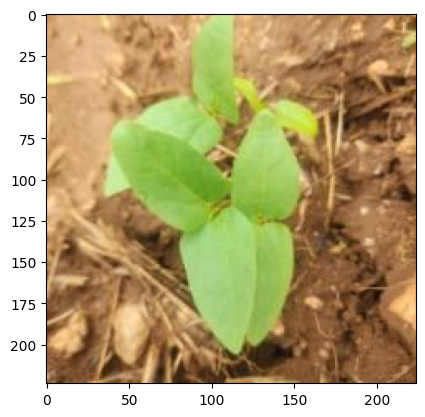

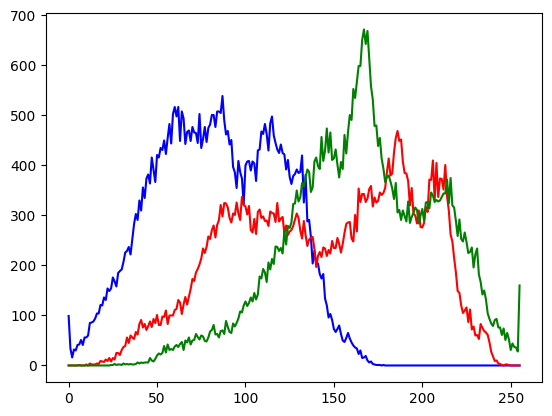

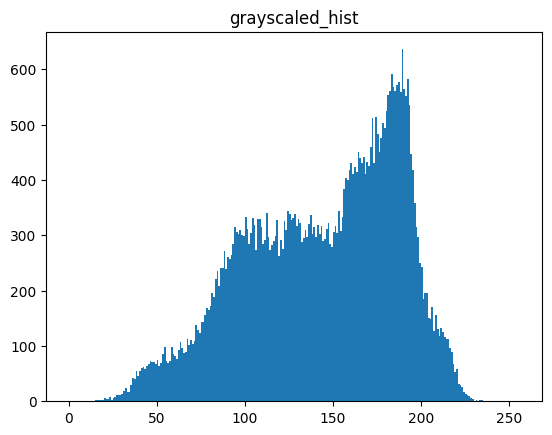

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted class:  0
Cowpea


In [24]:
!ls '/content/cowpeaweed/Test/Class0_Cowpea/'  # List files in the directory
# Reading and displaying an image
img = load_img(single_image_path, target_size = (img_size,img_size))
plt.figure(1)
plt.imshow(img)

# Viewing the BGR histogram of the respective image
plt.figure(2)
cv2_img = cv2.imread(single_image_path)
color = {'b', 'g', 'r'}
for i, col in enumerate(color):
  histr = cv2.calcHist(images=[cv2_img],channels=[i],mask=None,histSize=[256], ranges=[0,256])
  plt.plot(histr, color=col)
plt.show()

# Viewing the gray-scaled histogram of the respective image
plt.figure(3)
img_grayscaled = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)
plt.hist(img_grayscaled.ravel(), bins=256, range=[0,256])
plt.title('grayscaled_hist')
plt.show()

# Prediction of an image
input_arr = img_to_array(img)/255
input_arr = np.expand_dims(input_arr, axis = 0)
predictions = np.argmax(model.predict(input_arr), axis = -1)[0]
print("Predicted class: ", predictions)
print("Cowpea") if predictions == 0 else print("Grass weeds") if predictions == 1 else print("Broadleaf weeds")

### Predicting the classes of test data

In [19]:
# Declaring y_test
y_test= test_set.classes

# Finding the total number of test images
len_test_set = 0
for root, dirs, files in (os.walk(test_path)):
    for name in (files):
        len_test_set = len_test_set + 1

# Image prediction
y_pred = np.empty([len_test_set,1])
count = 0
for root, dirs, files in sorted(os.walk(test_path)):
    for name in sorted(files):
        img_path = os.path.join(root, name)
        img = load_img(img_path, target_size = (img_size,img_size))
        input_arr = img_to_array(img)/255
        input_arr = np.expand_dims(input_arr, axis = 0)
        y_pred[count] = np.argmax(model.predict(input_arr), axis = -1)[0]
        count = count + 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━